## Non-maximum Suppression and Species Classification

In this notebook, we will train a multi-class CNN for species classification. We will also write a function to pick top proposals from overlapping regions since we have multiple proposals per object. Now that we have our birds located, we can classify all region proposals and suppress regions with less confident predictions.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn
import cv2


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten,Dense, ZeroPadding2D, Dropout, Input,BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K

Using TensorFlow backend.


In [649]:
from collections import Counter
import random

In [4]:
train2=pd.read_csv('../data/bird2_train/train2_df.csv')
test1=pd.read_csv('../data/bird2_test/test1_df.csv')

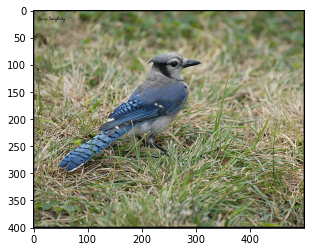

In [5]:
image = cv2.imread(test1['root'][17]+test1['filename'][15])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Load our model weights for object detection from previous notebook

In [6]:
json_file = open('../data/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('../data/bird_detector.h5')
print("Loaded model from disk")

Loaded model from disk


In [7]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [602]:
def det_obj(filename,threshold,color):
    '''function that reads a certain file and prediction threshold and uses our model to predict object of interest'''
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    w=image.shape[1]
    h=image.shape[0]
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    print(len(rects))
    rects[:10]
    test_sample=[]
    items=[]
    imout=image.copy()
    for i,item in enumerate(rects):
        if i<500:
            ##add segments to empty list
            items.append(item)
            x1=item[0]
            y1=item[1]
            x2=item[0]+item[2]
            y2=item[1]+item[3]
            cimage=imout[y1:y2,x1:x2]
            cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
            test_sample.append(cimage)
    test_sample_array=np.array(test_sample)   
    #predict all samlpes in our list
    test_sample_preds=loaded_model.predict(test_sample_array)
    fore=[]
    fore_score=[]
    for sample,label in zip(items,test_sample_preds):
        if label>threshold:
            fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
            #append positive samples above threshold
            fore.append(sample)
            
    fig,ax=plt.subplots(1)
    for i in fore:
        #place detections on image
        x,y,w,h=i
        box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor=color,facecolor='none')
        ax.add_patch(box)
        
    plt.imshow(image)
    

1175


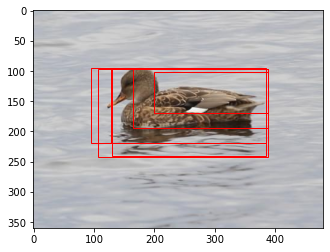

In [603]:
det_obj(test1['root'][1]+test1['filename'][51],.99,'red')

955


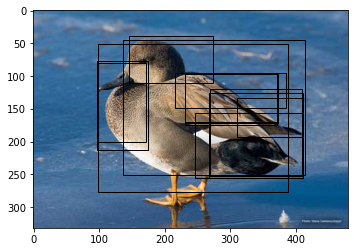

In [604]:
det_obj(test1['root'][1]+test1['filename'][45],.95,'black')

In [662]:
#lets bring our IoU calculation back in
def calc_iou(box1,box2):

    left_max=max(box1['x1'],box2['x1'])
    right_min=min(box1['x2'],box2['x2'])
    top_min=min(box1['y2'],box2['y2'])
    bottom_max=max(box1['y1'],box2['y1'])
    
    if right_min < left_max or top_min < bottom_max:
        return 0.0
    
    area_of_intersect=(right_min-left_max)*(top_min-bottom_max)
    area_of_union=((box1['y2']-box1['y1'])*(box1['x2']-box1['x1']))+((box2['y2']-box2['y1'])*(box2['x2']-box2['x1']))-area_of_intersect
    iou=(area_of_intersect)/(area_of_union)
    assert iou >= 0.0
    assert iou <= 1.0

    return iou

In [14]:
train2

,Unnamed: 0,root,filename,w,h,x1,x2,y1,y2
0,0,../data/bird2_train/,Blue_Jay_00.jpg,600,391,102,445,52,333
1,1,../data/bird2_train/,Blue_Jay_001.jpg,960,640,403,835,72,435
2,2,../data/bird2_train/,Blue_Jay_00111.jpg,480,360,42,430,43,269
3,3,../data/bird2_train/,Blue_Jay_0031.jpg,570,380,257,487,60,309
4,4,../data/bird2_train/,Blue_Jay_00343.jpg,540,346,118,472,35,245
...,...,...,...,...,...,...,...,...,...
641,641,../data/bird2_train/,Red_Winged_Blackbird_0097_jpg_423.jpg,750,552,146,650,90,365
642,642,../data/bird2_train/,Western_Meadowlark_0115_77882_jpg_424.jpg,500,439,164,379,54,327
643,643,../data/bird2_train/,Western_Meadowlark_0034_78869_jpg_425.jpg,461,500,204,326,157,302
644,644,../data/bird2_train/,Gadwall_0060_31686_jpg_426.jpg,500,333,112,424,78,296


## Model Setup

Lets set up our model similar to how we did in our previous notebook. We will segment out our images and classify regions with an IoU score above 0.7 by bird species.

In [15]:
train_images_s=[]
train_labels_s=[]
for i,item in enumerate(train2['filename']):


    box1={}
    box1['x1']=round(float(train2['x1'][i]))
    box1['x2']=round(float(train2['x2'][i]))
    box1['y1']=round(float(train2['y1'][i]))
    box1['y2']=round(float(train2['y2'][i]))
        
        
        
    image = cv2.imread(train2['root'][i]+train2['filename'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imout=image.copy()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    counter1=0
    for j,rect in enumerate(rects):
            #get top 2000 regions
            if j<2000:
                #assign proposed region coordinates to coordinate dictionary, similiar to our ground truth box.
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                #calculate IoU score of ground truth with proposal
                iou_score=calc_iou(box1,box3)
                #check to make sure there are less than 40 positive classes for this image
         
                    #if IoU score is high, greater than 0.7 lets assign it to positive class 1
                if iou_score>0.7:
                    #crop out proposal
                    timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                    #resize for model input resampling using pixel area relation
                    resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                    #add image data to our train set
                    
                    #specie names are in filenames, we will use filenames to separate classes
                    if 'Red_Winged' in item:
                        train_images_s.append(resized)
                        train_labels_s.append(1)

                    if 'Blue_Jay' in item:
                        train_images_s.append(resized)
                        train_labels_s.append(2)

                    if 'Cardinal' in item:
                        train_images_s.append(resized)
                        train_labels_s.append(3)

                        
                    if 'Horned_Grebe' in item:
                        train_images_s.append(resized)
                        train_labels_s.append(4)
    
                        
                    if 'Gadwall' in item:
                        train_images_s.append(resized)
                        train_labels_s.append(5)
 
                        
                    if 'Western' in item:
                        train_images_s.append(resized)
                        train_labels_s.append(6)

            
            
    
    
    

In [16]:
len(train_images_s)

4888

In [17]:
Counter(train_labels_s)

Counter({2: 549, 3: 737, 5: 979, 4: 685, 1: 1084, 6: 854})

In [18]:
test_images_s=[]
test_labels_s=[] 

for i,item in enumerate(test1['filename']):


    box1={}
    box1['x1']=round(float(test1['x1'][i]))
    box1['x2']=round(float(test1['x2'][i]))
    box1['y1']=round(float(test1['y1'][i]))
    box1['y2']=round(float(test1['y2'][i]))
        
        
        
    image = cv2.imread(test1['root'][i]+test1['filename'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imout=image.copy()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    counter1=0    
    for j,rect in enumerate(rects):
            #get top 2000 regions
            if j<2000:
                #assign proposed region coordinates to coordinate dictionary, similiar to our ground truth box.
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                #calculate IoU score of ground truth with proposal
                iou_score=calc_iou(box1,box3)
                #check to make sure there are less than 40 positive classes for this image
         
                    #if IoU score is high, greater than 0.7 lets assign it to positive class 1
                if iou_score>0.7:
                    #crop out proposal
                    timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                    #resize for model input resampling using pixel area relation
                    resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                    #add image data to our train set
                    if 'Red_Winged' in item:
                        test_images_s.append(resized)
                        test_labels_s.append(1)

                        
                    if 'Blue_Jay' in item:
                        test_images_s.append(resized)
                        test_labels_s.append(2)

                    if 'Cardinal' in item:
                        test_images_s.append(resized)
                        test_labels_s.append(3)

                        
                    if 'Horned_Grebe' in item:
                        test_images_s.append(resized)
                        test_labels_s.append(4)

                    if 'Gadwall' in item:
                        test_images_s.append(resized)
                        test_labels_s.append(5)

                    if 'Western' in item:
                        test_images_s.append(resized)
                        test_labels_s.append(6)
                          
                  
        

In [19]:
len(test_images_s)

1100

In [20]:
Counter(test_labels_s)

Counter({2: 129, 3: 248, 5: 260, 4: 124, 1: 164, 6: 175})

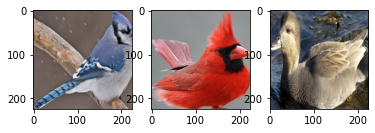

In [657]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(train_images_s[1])
ax2.imshow(train_images_s[411])
ax3.imshow(train_images_s[713])

In [21]:
X_train_s=np.array(train_images_s)

y_train_s=np.array(train_labels_s)
X_test_s=np.array(test_images_s)
y_test_s=np.array(test_labels_s)

## Species Classifier

We have pretty evenly split classes, so our baseline accuracy is 1/n=16.67%. Our Convolutional neural network has two blocks including a convulation layer, batch normalization for regularization, activation, and max pooling. This is connected to a fully connected neural network with 1 dense layers and 0.3 dropout. Our output layer is a dense layer with 6 nodes according to each class.

In [22]:
X_train_s.shape

(4888, 224, 224, 3)

In [23]:
from sklearn.preprocessing import OneHotEncoder
oh=OneHotEncoder(sparse=False,dtype=int,categories='auto')
y_train_s=oh.fit_transform(y_train_s.reshape(-1,1))
y_test_s=oh.transform(y_test_s.reshape(-1,1))

In [24]:
cnn1=Sequential()
cnn1.add(Conv2D(16,(3,3),input_shape=(224,224,3)))
cnn1.add(BatchNormalization()) 
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
cnn1.add(Conv2D(32,(3,3)))
cnn1.add(BatchNormalization()) 
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.3))
#cnn1.add(Dense(500, activation='softmax'))
cnn1.add(Dense(6,activation='softmax'))


In [25]:
early_stop=EarlyStopping(monitor='accuracy',min_delta=0,patience=5,verbose=1,mode='auto')

In [26]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#early_stop=EarlyStopping(monitor='val_accuracy',min_delta=0,patience=5,verbose=1,mode='auto')
history = cnn1.fit(X_train_s,
                        y_train_s,
                        batch_size=32,
                        validation_data=(X_test_s, y_test_s),
                        epochs=50,
                        verbose=1,callbacks=[early_stop])

Train on 4888 samples, validate on 1100 samples
Epoch 1/50
4888/4888 [==============================] - 14s 3ms/sample - loss: 4.9324 - accuracy: 0.4736 - val_loss: 1.3149 - val_accuracy: 0.5355
Epoch 2/50
4888/4888 [==============================] - 12s 2ms/sample - loss: 1.2398 - accuracy: 0.5751 - val_loss: 1.1803 - val_accuracy: 0.5555
Epoch 3/50
4888/4888 [==============================] - 12s 2ms/sample - loss: 1.2093 - accuracy: 0.5775 - val_loss: 0.9831 - val_accuracy: 0.6309
Epoch 4/50
4888/4888 [==============================] - 12s 2ms/sample - loss: 1.0398 - accuracy: 0.6430 - val_loss: 1.0282 - val_accuracy: 0.6955
Epoch 5/50
4888/4888 [==============================] - 12s 3ms/sample - loss: 0.9645 - accuracy: 0.6876 - val_loss: 0.7878 - val_accuracy: 0.7527
Epoch 6/50
4888/4888 [==============================] - 12s 2ms/sample - loss: 0.9701 - accuracy: 0.6659 - val_loss: 1.7192 - val_accuracy: 0.6609
Epoch 7/50
4888/4888 [==============================] - 12s 2ms/sample

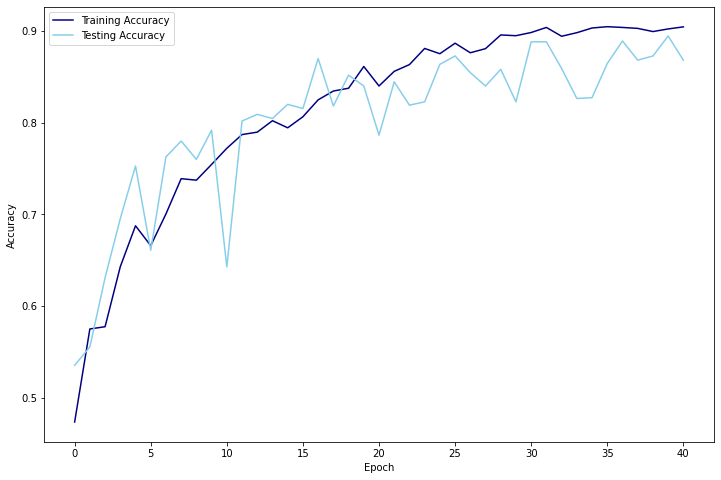

In [435]:
train_loss=history.history['accuracy']
test_loss=history.history['val_accuracy']
plt.figure(figsize=(12,8))
plt.plot(train_loss,label='Training Accuracy', color='navy')
plt.plot(test_loss,label='Testing Accuracy',color='skyblue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

## Non-max suppression

As we see above, we have multiple proposals per object. In order to solve this problem we will use a function to group nearby proposals and remove regions with lower probabilities so we end up up with our strongest prediction per object. Reference video [Andrew Ng's C4W3L07](https://www.youtube.com/watch?v=VAo84c1hQX8&t=341s)

In [511]:
labels=['Red_winged','Blue_jay','Cardinal','Horned_grebbe','Gadwall','Western']

In [663]:
def cluster_regions(ziplist,threshold,textcolor,boxcolor):
    
    '''Acceps a list of probabilities and associated bounding boxes.
    We will group up overlapping regions and rank them on prediction '''
    
    
    labels=['Red_winged','Blue_jay','Cardinal','Horned_grebbe','Gadwall','Western']
    ##sort by y2, we will use a bottom-up approach
    final_y2 = sorted(ziplist, key = lambda x: x[1][3],reverse=True) 
    ##set our first box to be box with highest y2
    prio_=final_y2[0][1]

    box1={}
    box1['x1']=prio_[0]
    box1['y1']=prio_[1]
    box1['x2']=prio_[0]+prio_[2]
    box1['y2']=prio_[1]+prio_[3]
    list1=[]
    list1.append(final_y2[0])
    
    list2=[]
    count1=0
    #loop through rest of boxes and calculate iou
    for i in final_y2[1:]:
        box2={}
        box2['x1']=i[1][0]
        box2['y1']=i[1][1]
        box2['x2']=i[1][0]+i[1][2]
        box2['y2']=i[1][1]+i[1][3]
        iou=calc_iou(box1,box2)
        #if overlap score is high enough, group together 
        if iou>threshold:
            list1.append(i)
        # if overlap score is too low, send to second group for recursion
        else:
            count1+=1
            if count1==1:
                list2=[]
                list2.append(i)
            else:
                list2.append(i)
            
    #get most frequent prediction(which species) in our group overlapped regions.          
    top=[]
    for i in list1:
        top.append(list(i[0]).index(max(list(i[0]))))
    max1=0
    
    for i in top: 
        freq = top.count(i) 
        if freq > max1: 
            max1 = freq 
            res = i 
    #sort our list by most frequently predicted species probability
    final = sorted(list1, key = lambda x: x[0][res],reverse=True) 
    #get highest probability bounding box
    x,y,w,h=final[0][1]
    #plot box
    box=patches.Rectangle((x,y),w,h,linewidth=2,edgecolor=boxcolor,facecolor='none')
    ax.add_artist(box)
    #annotate box with prediction label and probability
    ax.text(x+w, y-40, f'{labels[res]}' + f' - {round(final[0][0][res],2)*100}%',
             horizontalalignment='right', verticalalignment='bottom',color=textcolor)
    new_list=final[0][0]
    
    new_list.remove(max(final[0][0]))
    #remove current max so we can get second highest
    del labels[new_list.index(max(new_list))]
    #del the last max's label
    res2=new_list.index(max(new_list))
    #set new label
    
    #annotate second highest box with prediction label and probability
    ax.text(x+w, y-20, f'{labels[res2]}' + f' - {round(max(final[0][0]),2)*100}%',
             horizontalalignment='right', verticalalignment='bottom',color=textcolor)
    
    new_list.remove(max(final[0][0]))
    del labels[new_list.index(max(new_list))]
    res2=new_list.index(max(new_list))
    #annotate third highest box with prediction label and probability

    ax.text(x+w, y, f'{labels[res2]}' + f' - {round(max(final[0][0]),2)*100}%',
             horizontalalignment='right', verticalalignment='bottom',color=textcolor)
    
    
    ax.add_patch(box)
    ##if our second list has entries, rerun function with same parameters
    if len(list2)>1:
        cluster_regions(list2,threshold,textcolor,boxcolor)
    
    

In [627]:
def cluster_regions1(ziplist,threshold,textcolor,boxcolor):
    
    ''' simpler function, only gives top predictions'''
    
    
    labels=['Red_winged','Blue_jay','Cardinal','Horned_grebbe','Gadwall','Western']
    ##sort by y2, we will use a bottom-up approach
    final_y2 = sorted(ziplist, key = lambda x: x[1][3],reverse=True) 
    ##set our first box to be box with high y2
    prio_=final_y2[0][1]

    box1={}
    box1['x1']=prio_[0]
    box1['y1']=prio_[1]
    box1['x2']=prio_[0]+prio_[2]
    box1['y2']=prio_[1]+prio_[3]
    list1=[]
    list1.append(final_y2[0])
    
    list2=[]
    count1=0

    for i in final_y2[1:]:
        box2={}
        box2['x1']=i[1][0]
        box2['y1']=i[1][1]
        box2['x2']=i[1][0]+i[1][2]
        box2['y2']=i[1][1]+i[1][3]
        iou=calc_iou(box1,box2)
        if iou>threshold:
            list1.append(i)
        else:
            count1+=1
            if count1==1:
                list2=[]
                list2.append(i)
            else:
                list2.append(i)
            
            
    top=[]
    for i in list1:
        top.append(list(i[0]).index(max(list(i[0]))))
    max1=0
    
    for i in top: 
        freq = top.count(i) 
        if freq > max1: 
            max1 = freq 
            res = i 

    final = sorted(list1, key = lambda x: x[0][res],reverse=True) 
    x,y,w,h=final[0][1]
    box=patches.Rectangle((x,y),w,h,linewidth=2,edgecolor=boxcolor,facecolor='none')
    ax.add_artist(box)
    ax.text(x+w, y, f'{labels[res]}' + f' - {round(final[0][0][res],2)*100}%',
             horizontalalignment='right', verticalalignment='bottom',color=textcolor)
    new_list=final[0][0]
    

    
    ax.add_patch(box)
    
    if len(list2)>1:
        cluster_regions1(list2,threshold,textcolor,boxcolor)
    
    

645


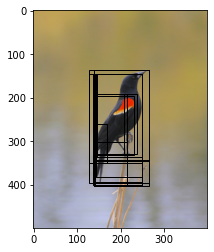

In [622]:
det_obj(test1['root'][1]+test1['filename'][77],.65,'black')

Above we have our object detector at work accurately localizing our bird.

645


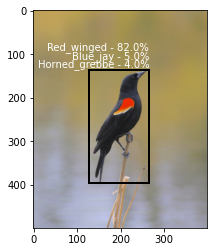

In [599]:
image = cv2.imread(test1['root'][1]+test1['filename'][77])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<500:
        ##add segments to empty list
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)   
#predict all samlpes in our list
test_sample_preds=loaded_model.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.95:
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
        #append positive samples above threshold
        fore.append(sample)
        fore_score.append(label)
        
test_s=[]
for item in fore:
    x1=item[0]
    y1=item[1]
    x2=item[0]+item[2]
    y2=item[1]+item[3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_s.append(cimage)
test_s_array=np.array(test_s)   
#predict all samlpes in our list
test_s_preds=cnn1.predict(test_s_array)

preds1=test_s_preds.tolist()    
zipped = zip(preds1, fore)
fig,ax=plt.subplots(1)
cluster_regions(zipped,0.1,'white','black')

plt.imshow(image)


After non_max suppression we have correctly classified a red-winged blackbird. We have displayed top 3 species predictions above the bounding box.

915


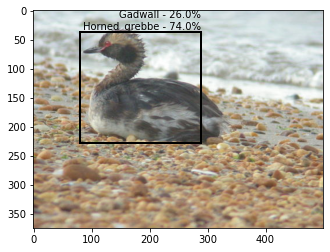

In [595]:
image = cv2.imread(test1['root'][1]+test1['filename'][64])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<500:
        ##add segments to empty list
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)   
#predict all samlpes in our list
test_sample_preds=loaded_model.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.95:
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
        #append positive samples above threshold
        fore.append(sample)
        fore_score.append(label)
        
test_s=[]
for item in fore:
    x1=item[0]
    y1=item[1]
    x2=item[0]+item[2]
    y2=item[1]+item[3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_s.append(cimage)
test_s_array=np.array(test_s)   
#predict all samlpes in our list
test_s_preds=cnn1.predict(test_s_array)

preds1=test_s_preds.tolist()    
zipped = zip(preds1, fore)
fig,ax=plt.subplots(1)
cluster_regions(zipped,0.1,'black','black')

plt.imshow(image)


Correct Horned Grebbe prediction and classification

594


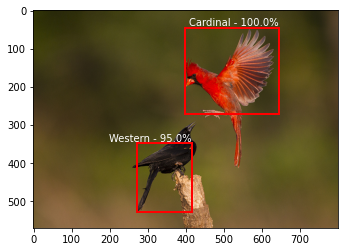

In [628]:
image = cv2.imread('../data/AT1F6839-Northern-Cardinal-&-Redwing-Blackbird-_-800.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<500:
        ##add segments to empty list
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)   
#predict all samlpes in our list
test_sample_preds=loaded_model.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.95:
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
        #append positive samples above threshold
        fore.append(sample)
        fore_score.append(label)
        
test_s=[]
for item in fore:
    x1=item[0]
    y1=item[1]
    x2=item[0]+item[2]
    y2=item[1]+item[3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_s.append(cimage)
test_s_array=np.array(test_s)   
#predict all samlpes in our list
test_s_preds=cnn1.predict(test_s_array)

preds1=test_s_preds.tolist()    
zipped = zip(preds1, fore)
fig,ax=plt.subplots(1)
cluster_regions1(zipped,0.1,'white','red')

plt.imshow(image)


Above we have correct detections, but our Red-Winged blackbird is being predicted as Western Meadowlark

1837


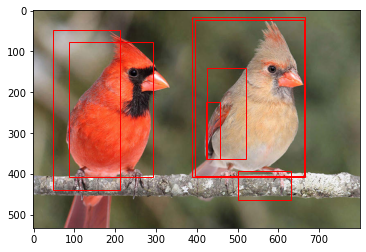

In [659]:
det_obj('../data/Pair-of-Northern-Cardinals.jpg',.95,'red')

1837


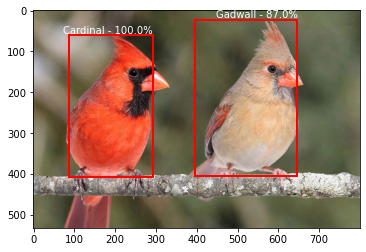

In [644]:
image = cv2.imread('../data/Pair-of-Northern-Cardinals.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<700:
        ##add segments to empty list
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)   
#predict all samlpes in our list
test_sample_preds=loaded_model.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.99:
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
        #append positive samples above threshold
        fore.append(sample)
        fore_score.append(label)
        
test_s=[]
for item in fore:
    x1=item[0]
    y1=item[1]
    x2=item[0]+item[2]
    y2=item[1]+item[3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_s.append(cimage)
test_s_array=np.array(test_s)   
#predict all samlpes in our list
test_s_preds=cnn1.predict(test_s_array)

preds1=test_s_preds.tolist()    
zipped = zip(preds1, fore)
fig,ax=plt.subplots(1)
cluster_regions1(zipped,0.01,'white','red')

plt.imshow(image)


As you can see , we have successfully identified both birds. However, our cardinal on the right is not being classified correctly. This is mainly due to our classifier only training cardinals on images of male cardinals, while the cardinal on the right is a female cardinal.

3130


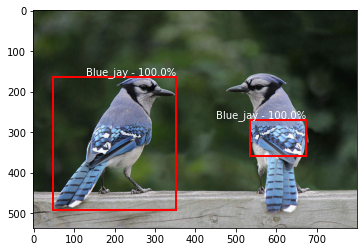

In [664]:
image = cv2.imread('../data/Pair-of-Blue-Jays-Sitting-on-Railing.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<700:
        ##add segments to empty list
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)   
#predict all samlpes in our list
test_sample_preds=loaded_model.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.99:
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
        #append positive samples above threshold
        fore.append(sample)
        fore_score.append(label)
        
test_s=[]
for item in fore:
    x1=item[0]
    y1=item[1]
    x2=item[0]+item[2]
    y2=item[1]+item[3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_s.append(cimage)
test_s_array=np.array(test_s)   
#predict all samlpes in our list
test_s_preds=cnn1.predict(test_s_array)

preds1=test_s_preds.tolist()    
zipped = zip(preds1, fore)
fig,ax=plt.subplots(1)
cluster_regions1(zipped,0.01,'white','red')

plt.imshow(image)


551


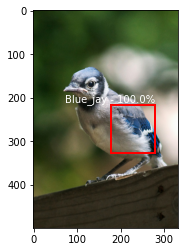

In [661]:
image = cv2.imread('../data/bird2_test/Blue_Jay_0024_63167.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<700:
        ##add segments to empty list
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)   
#predict all samlpes in our list
test_sample_preds=loaded_model.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.99:
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
        #append positive samples above threshold
        fore.append(sample)
        fore_score.append(label)
        
test_s=[]
for item in fore:
    x1=item[0]
    y1=item[1]
    x2=item[0]+item[2]
    y2=item[1]+item[3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_s.append(cimage)
test_s_array=np.array(test_s)   
#predict all samlpes in our list
test_s_preds=cnn1.predict(test_s_array)

preds1=test_s_preds.tolist()    
zipped = zip(preds1, fore)
fig,ax=plt.subplots(1)
cluster_regions1(zipped,0.01,'white','red')

plt.imshow(image)


Our detector picks up our bird, for the most part. It does give as an accurate prediction.

646


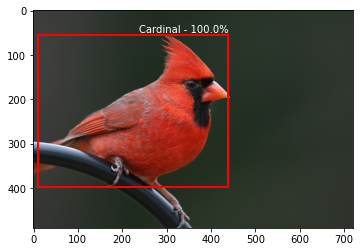

In [666]:
image = cv2.imread(test1['root'][1]+test1['filename'][31])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<700:
        ##add segments to empty list
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)   
#predict all samlpes in our list
test_sample_preds=loaded_model.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.99:
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
        #append positive samples above threshold
        fore.append(sample)
        fore_score.append(label)
        
test_s=[]
for item in fore:
    x1=item[0]
    y1=item[1]
    x2=item[0]+item[2]
    y2=item[1]+item[3]
    cimage=imout[y1:y2,x1:x2]
    cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
    test_s.append(cimage)
test_s_array=np.array(test_s)   
#predict all samlpes in our list
test_s_preds=cnn1.predict(test_s_array)

preds1=test_s_preds.tolist()    
zipped = zip(preds1, fore)
fig,ax=plt.subplots(1)
cluster_regions1(zipped,0.01,'white','red')

plt.imshow(image)


## Conclusion and Recommendations.

We trained a binary classification CNN for object detection achieving 95% testing accuracy and 98.8% training accuracy, which is significantly higher than our 72.6% threshold. Looking over our false positives and false negatives, our model still needs some fine tuning as the presence of false positives will greatly interfere with our detection process. A relatively small sample size was used, we had around 300 images that segmented out to around 22k observations with a 17k/5k train test split.

We then trained a multi a multi-classification CNN for species classification achieving a training accuracy of 90% and testing accuracy of 86.8%. This is also siginificantly higher than our 16.67% accuracy threshold.

We noticed our positive samples are not perfect pixel-for-pixel representations of what we are actually detection, our bird. Our samples are bounding boxes that also bring in random noise. So different species of birds will tend to have different background noise that we will also be classifying on.

We made the realization that the presence of false positives is detrimental to detection. We can use our AUC-ROC curve to reevaluate our probability threshold for predictions and adjust True Positive and False Positive tradeoff for stronger deployment. A higher threshold (>0.9) reduced false positive detection and still provided enough true positives to work with.

For further steps and more time, we can obtain more data, gridsearch parameters, and use ModelCheckpoints to tune our CNN and deploy it in the setting we are targeting. 

## Sources

- https://medium.com/@wenrudong/what-is-opencvs-inter-area-actually-doing-282a626a09b3
- https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55
- https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/
- https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
- http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

## Full detection function

dont use yet

In [542]:
# def full_detect(file,thresh1,thresh2):
#     image = cv2.imread(file)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     w=image.shape[1]
#     h=image.shape[0]
#     ss.setBaseImage(image)
#     ss.switchToSelectiveSearchFast()
#     rects = ss.process()
#     print(len(rects))
#     rects[:10]
#     test_sample=[]
#     items=[]
#     imout=image.copy()
#     for i,item in enumerate(rects):
#         if i<500:
#             ##add segments to empty list
#             items.append(item)
#             x1=item[0]
#             y1=item[1]
#             x2=item[0]+item[2]
#             y2=item[1]+item[3]
#             cimage=imout[y1:y2,x1:x2]
#             cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
#             test_sample.append(cimage)
#     test_sample_array=np.array(test_sample)   
#     #predict all samlpes in our list
#     test_sample_preds=loaded_model.predict(test_sample_array)
#     fore=[]
#     fore_score=[]
#     for sample,label in zip(items,test_sample_preds):
#         if label>thresh1:
#             fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
#             #append positive samples above threshold
#             fore.append(sample)
#             fore_score.append(label)
            
#     test_s=[]
#     for item in fore:
#         x1=item[0]
#         y1=item[1]
#         x2=item[0]+item[2]
#         y2=item[1]+item[3]
#         cimage=imout[y1:y2,x1:x2]
#         cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
#         test_s.append(cimage)
#     test_s_array=np.array(test_s)   
#     #predict all samlpes in our list
#     test_s_preds=cnn1.predict(test_s_array)
    
#     preds1=test_s_preds.tolist()    
#     zipped = zip(preds1, fore)
#     fig,ax=plt.subplots(1)
#     final_y2 = sorted(zipped, key = lambda x: x[1][3],reverse=True) 
#     ##set our first box to be box with high y2
#     prio_=final_y2[0][1]

#     box1={}
#     box1['x1']=prio_[0]
#     box1['y1']=prio_[1]
#     box1['x2']=prio_[0]+prio_[2]
#     box1['y2']=prio_[1]+prio_[3]
#     list1=[]
#     list1.append(final_y2[0])
    
#     list2=[]
#     count1=0

#     for i in final_y2[1:]:
#         box2={}
#         box2['x1']=i[1][0]
#         box2['y1']=i[1][1]
#         box2['x2']=i[1][0]+i[1][2]
#         box2['y2']=i[1][1]+i[1][3]
#         iou=calc_iou(box1,box2)
#         if iou>.01:
#             list1.append(i)
#         else:
#             count1+=1
#             if count1==1:
#                 list2=[]
#                 list2.append(i)
#             else:
#                 list2.append(i)
            
            
#     top=[]
#     for i in list1:
#         top.append(list(i[0]).index(max(list(i[0]))))
#     max1=0
    
#     for i in top: 
#         freq = top.count(i) 
#         if freq > max1: 
#             max1 = freq 
#             res = i 

#     final = sorted(list1, key = lambda x: x[0][res],reverse=True) 
#     x,y,w,h=final[0][1]
#     box=patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='red',facecolor='none')
#     ax.add_artist(box)
#     ax.text(x+w, y, f'{labels[res]}' + f'{round(final[0][0][res],2)*100}',
#              horizontalalignment='right', verticalalignment='top',color='white')
#     ax.add_patch(box)
    
#     if len(list2)>1:
#         cluster_regions(list2,threshold)
    
    
    
#     plt.imshow(image)
    